# WIP
## IES - Python - Project
### Marathon Results
### Data analysis
#### David Koubek, Jiri Zelenka

### Content
#### Import Required Packages
#### Data Loading + Merging
#### Technical Improvements:
##### - Renaming Columns + Adding Gender
##### - Cleaning Time + Adding Minutes
##### - Cleaning Names of Runners
-------------------------------------
#### Unique Countries, Names and Ages
#### Runners who Repeated Marathon
#### Percentage of Czechs Over Time
-------------------------------------
#### Pivot tables - Year x Gender
###### Min rank
###### Min time
###### Mean time
-------------------------------------
##### Top 5 countries with the most of Runners - Mean + Min 
##### Continents - Sfrice vs Europe vs USA
-------------------------------------
#### Medals
-------------------------------------
#### M/W Histograms over years

### Import required packages.

In [1]:
import pandas as pd # for dataframe
import numpy as np  # working with arrays
import matplotlib.pyplot as plt  # Basic plots
import seaborn as sns   # Plots, boxplots
import gender_guesser.detector as gender   # Gender predictions

from collections import Counter

In [2]:
# Setup  for the basic graphs

plt.rcParams["figure.figsize"]=(14,8)

### Data loading + Merging

#### 1995 - 2019 (excluding 2012)

In [3]:
years = [1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
         2005, 2006, 2007, 2008, 2009, 2010, 2011, # 2012 is missing !!!, 24 runs
         2013, 2014, 2015, 2016, 2017, 2018, 2019]

df_all = []

for i in years:
    df = pd.read_csv('../Scraper/Data_Marathons_Prague/data_' + str(i) + '.csv')
    df["Year"] = i
    df_all.append(df)
    
#  this creates a list of dfs, possible to get inside with indexes [1]...


df_merged = pd.concat(df_all, ignore_index=True)   # Important for obtaining overall index

len(df_merged)

94299

In [4]:
df_merged.head()
# df_merged.tail()

,Rank,Name,Chip time,St. number,Nationality,Age cat.,Year
0,1,Turbo Tummo,2:12:44,3,-,-,1995
1,2,Andrzej Krzyscin,2:16:53,8,-,-,1995
2,3,Pavel Klimes,2:16:56,7,-,-,1995
3,4,Miriusz Kaminski,2:17:06,28,-,-,1995
4,5,Jackson Kipngok,2:17:13,1,-,-,1995


### Technical Improvements

#### Renaming Columns + Adding Gender
#### Cleaning Time + Adding Minutes
#### Cleaning Names of Runners

In [5]:

### Renaming Columns

df_renamed = df_merged.rename(columns={"Age cat.":"Age", "Chip time":"Time","St. number":"Start_number"  })

## Adding Gender column  

df_renamed["Gender"] = df_renamed["Age"].astype(str).str[0]

# df_renamed.head()
df_renamed.tail()

,Rank,Name,Time,Start_number,Nationality,Age,Year,Gender
94294,7296,Jaroslav Sopuch,6:45:30,4652,SVK,M65,2019,M
94295,7297,Dong Tran,6:39:37,7542,VNM,MAM,2019,M
94296,7298,Jiří Přidal,6:57:39,6743,CZE,M65,2019,M
94297,7299,Iva Valentová,6:42:54,F2060,CZE,W45,2019,W
94298,7300,EHUD AVNI,6:59:04,7331,ISR,M50,2019,M


In [6]:

### Time Cleaning

    # Deleting 288 observations with time = "-" - mostly from year 1998, reason of this = ???
df_times = df_renamed[df_renamed.Time != "-"]

df_times.reset_index(drop = True,inplace=True)

    # Check for non-"-" times
times = df_times["Time"]
times.describe()

len(df_times)

# Keep working with 94 011 Runners = df_times


94011

In [7]:

### Counting minutes from Total time

tot_min = []
times = list(times)

for i in times:
    t=i.split(':')
    tot_min.append(int(t[0])*60+int(t[1])*1 +int(t[2])/60)
    
# len(tot_min)
tot_min = pd.DataFrame(tot_min)

df_mins = pd.concat([df_times, tot_min], axis=1)
df_mins = df_mins.rename(columns={0:"tot_mins"})


In [8]:
    # List of roudned minutes

Mins = list(np.around(np.array(tot_min),0))
Mins = pd.DataFrame(Mins)

df_mins = pd.concat([df_mins, Mins], axis=1)
df_mins = df_mins.rename(columns={0:"Mins"})

df_mins.head()
# df_mins.tail()

# Keep working with Dataframe including rounded minutes = df_mins


,Rank,Name,Time,Start_number,Nationality,Age,Year,Gender,tot_mins,Mins
0,1,Turbo Tummo,2:12:44,3,-,-,1995,-,132.733333,133.0
1,2,Andrzej Krzyscin,2:16:53,8,-,-,1995,-,136.883333,137.0
2,3,Pavel Klimes,2:16:56,7,-,-,1995,-,136.933333,137.0
3,4,Miriusz Kaminski,2:17:06,28,-,-,1995,-,137.100000,137.0
4,5,Jackson Kipngok,2:17:13,1,-,-,1995,-,137.216667,137.0


In [9]:

###  Cleaning Names:

all_names = list(df_mins.Name)

#print(sorted(all_names))

# print(sorted(all_names)[0:500])
# print(sorted(all_names)[len(all_names)-500:len(all_names)])

    # In the head we can see some names starting with spaces or dots - we will transform them.
    # In the tail there are names of Russian, Israeili, Chiense or Japanese Runners.
    # There are not so many of them, we keep them in original form


In [10]:
indd = df_mins.index[df_mins['Name'] == ' Peter Puškár                   '].tolist()
df_mins.loc[indd,'Name'] = "Peter Puškár"
indd = df_mins.index[df_mins['Name'] == ' Radek Podracký               '].tolist()
df_mins.loc[indd,'Name'] = "Radek Podracký"
indd = df_mins.index[df_mins['Name'] == ' STEINIVAR'].tolist()
df_mins.loc[indd,'Name'] = "STEINIVAR"
indd = df_mins.index[df_mins['Name'] == ',Jiří Stránský Judr.'].tolist()
df_mins.loc[indd,'Name'] = "Jiří Stránský Judr."
indd = df_mins.index[df_mins['Name'] == '.Jiří Nekuža'].tolist()
df_mins.loc[indd,'Name'] = "Jiří Nekuža"
indd = df_mins.index[df_mins['Name'] == '- 50008873'].tolist()
df_mins.loc[indd,'Name'] = "- -"
indd = df_mins.index[df_mins['Name'] == '- 50044654'].tolist()
df_mins.loc[indd,'Name'] = "- -"
indd = df_mins.index[df_mins['Name'] == '?IVIND JOHANSEN'].tolist()
df_mins.loc[indd,'Name'] = "IVIND JOHANSEN"
indd = df_mins.index[df_mins['Name'] == '\u202aesty rosenberg\u202c\u200f'].tolist()
df_mins.loc[indd,'Name'] = "aesty rosenberg"
indd = df_mins.index[df_mins['Name'] == '\u202aron gashri\u202c\u200f'].tolist()
df_mins.loc[indd,'Name'] = "aron gashri"
indd = df_mins.index[df_mins['Name'] == 'ＨＩＲＯＫＯ ＫＵＳＵＮＯＫＩ'].tolist()
df_mins.loc[indd,'Name'] = "Hiroko Kusunoki"
indd = df_mins.index[df_mins['Name'] == 'ＨＩＲＯＫＯ ＳＨＩＮＯＭＩＹＡ'].tolist()
df_mins.loc[indd,'Name'] = "Hiroko Shinomiya"
indd = df_mins.index[df_mins['Name'] == 'ＨＩＲＯＭＩ ＹＯＮＥＺＵ'].tolist()
df_mins.loc[indd,'Name'] = "Hiromi Yonezu"
indd = df_mins.index[df_mins['Name'] == 'ＪＵＮＫＯ ＮＩＳＨＩＯＫＡ'].tolist()
df_mins.loc[indd,'Name'] = "Junko Nishioka"
indd = df_mins.index[df_mins['Name'] == 'ＫＩＳＡＫＯ ＴＯＫＯ'].tolist()
df_mins.loc[indd,'Name'] = "Kisako Toko"
indd = df_mins.index[df_mins['Name'] == 'ＫＩＹＯＫＯ ＫＡＷＡＳＡＫＩ'].tolist()
df_mins.loc[indd,'Name'] = "Kiyoko Kawasaki"
indd = df_mins.index[df_mins['Name'] == 'ＭＡＳＡＫＯ ＯＮＩＳＨＩ'].tolist()
df_mins.loc[indd,'Name'] = "Masako Onishi"
indd = df_mins.index[df_mins['Name'] == 'ＭＩＥＫＯ ＴＳＵＪＩＯＫＡ'].tolist()
df_mins.loc[indd,'Name'] = "Mieko Tsujioka"

In [11]:

# Checking the names

all_names_new = list(df_mins.Name)

#print(sorted(all_names_new)[0:500])
# print(sorted(all_names_new)[len(all_names_new)-500:len(all_names_new)])

In [12]:
df_mins['Name'] = [str(i).lower() for i in df_mins['Name']] 
   # Changing all to lowercase
    
df_final = df_mins

In [13]:
# Doplnění Ranků ... #############tRANSLATE PLS#############

missing_ranks = list(range(1601,1640))
missing_ranks = list(map(str, missing_ranks))

len(missing_ranks)
len(df_final.loc[df_final['Rank']=="-","Rank"])
# Check of the length of source and target = OK

df_final.loc[df_final['Rank']=="-","Rank"] = missing_ranks

df_final[df_final["Year"]==1997].tail(40)
    # Check of the new Ranks

,Rank,Name,Time,Start_number,Nationality,Age,Year,Gender,tot_mins,Mins
3285,1600,barbora dohnalová,5:10:36,393,TCH,WAM,1997,W,310.600000,311.0
3286,1601,jan prosecký,5:10:43,3857,TCH,MAM,1997,M,310.716667,311.0
3287,1602,véronique bruneau,5:12:46,336,FRA,WAM,1997,W,312.766667,313.0
3288,1603,jiří mareš,5:12:57,3760,TCH,MAM,1997,M,312.950000,313.0
3289,1604,miloslav kníže,5:12:58,3639,TCH,MAM,1997,M,312.966667,313.0
3290,1605,ladislav hnízdil,5:14:31,2975,TCH,M60,1997,M,314.516667,315.0
3291,1606,melissa stark,5:16:11,319,GBR,WAM,1997,W,316.183333,316.0
3292,1607,eduard bartek,5:16:12,3511,TCH,MAM,1997,M,316.200000,316.0
3293,1608,josef kocourek,5:16:17,3652,TCH,MAM,1997,M,316.283333,316.0
3294,1609,miroslav hofman,5:16:33,3859,TCH,M40,1997,M,316.550000,317.0


In [14]:
# All Ranks change into Integers   

df_final["Rank"] = pd.to_numeric(df_final["Rank"])

### Unique Countries, Names and Ages

In [15]:
#All unique countries:

uq_countries = df_final.Nationality.unique()   
len(uq_countries)

# uq_countries

205

In [16]:
# All unique ages:

uq_ages = df_final.Age.unique()
len(uq_ages)

# uq_ages

15

In [17]:
# All unique names:

uq_names = df_final.Name.unique()
len(uq_names)

# uq_names

66087

### Runners who Repeated Marathon

In [18]:



# Count how many names are in multiple runs (not in the same run) and in how many:

all_names = list(df_final.Name)
num_of_runs = Counter(all_names)

#num_of_runs.most_common()NaRuns 

##################################################
# Cannot say: ... .. Petr Svoboda vs ("jack joseph michel brossaud")

### Top 5 Countries of origins

In [19]:
all_names = list(df_final.Nationality)
num_of_countries = Counter(all_names)

top5 = num_of_countries.most_common(5)
top5 = [i[0] for i in top5]
top5

['CZE', 'FRA', 'ITA', 'GBR', 'GER']

In [20]:
#############################x Dokončit

### Percentage of Czechs Over Time

In [21]:
# Percentage of Czechs

# After inspecting each year, we noticed of the occurence of "TCH"
# instead of "CZE" in Nationality column.

# 1995 - no nationalities
# 1996 2x CZE + 0x TCH
# 1997 1x CZE + 727x TCH
# 1998 1x CZE + 1045x TCH
# 1999 986x CZE + 0x TCH
# ... CZE only


# Replacing all "TCH" with "CZE"

df_final['Nationality'] = df_final['Nationality'].replace('TCH', 'CZE')     ################x Přesunout na začátek a zmínit 

In [22]:
years = [1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
         2005, 2006, 2007, 2008, 2009, 2010, 2011, 
         2013, 2014, 2015, 2016, 2017, 2018, 2019]

# 2012 is missing, 1995 and 1996 is excluded, 22 runs

In [23]:
# Percents of czech Runners over years 1997-2019

cz_percent = []
for year in years:
    
    cz = len(df_final[(df_final["Nationality"] == "CZE") & (df_final["Year"] == year)])
    alls = len(df_final[df_final["Year"] == year])
    per = cz/alls
    cz_percent.append(per)
    
cz_percent

[0.4441732763880415,
 0.47074707470747074,
 0.35442127965492454,
 0.43695965417867433,
 0.43089738735327526,
 0.4439302242791029,
 0.4700230591852421,
 0.5284008156131663,
 0.39094650205761317,
 0.36576395854229354,
 0.4150470219435737,
 0.4123543755079924,
 0.408953722334004,
 0.4033751800782054,
 0.42630385487528344,
 0.5152618799861256,
 0.5562777967841259,
 0.569919945494805,
 0.5627488315734811,
 0.47634408602150535,
 0.4828776978417266,
 0.500958904109589]

In [24]:
czechs = df_final[df_final["Nationality"] == "CZE"]
len(czechs)/len(df_final)

# Overall percentage of czech Runners = 46.2 %


0.462105498292753

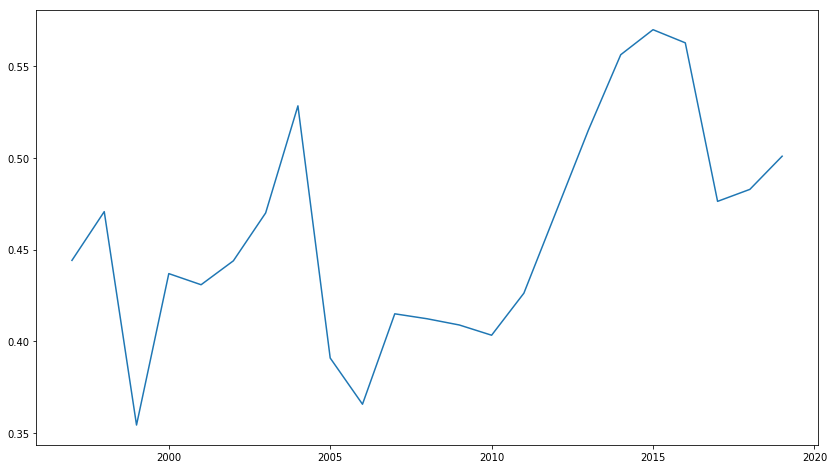

In [25]:


plt.plot(years, cz_percent)
plt.show()

################################# Graph Title

## Gender Section

In [27]:
Forename = []
for i in df_final["Name"]:
    ni = i.split(' ')
    Forename.append(ni[0].capitalize())

df_final["Forename"]=Forename

df_final[df_final["Gender"]=="-"].head()

,Rank,Name,Time,Start_number,Nationality,Age,Year,Gender,tot_mins,Mins,Forename
0,1,turbo tummo,2:12:44,3,-,-,1995,-,132.733333,133.0,Turbo
1,2,andrzej krzyscin,2:16:53,8,-,-,1995,-,136.883333,137.0,Andrzej
2,3,pavel klimes,2:16:56,7,-,-,1995,-,136.933333,137.0,Pavel
3,4,miriusz kaminski,2:17:06,28,-,-,1995,-,137.100000,137.0,Miriusz
4,5,jackson kipngok,2:17:13,1,-,-,1995,-,137.216667,137.0,Jackson


In [28]:
d = gender.Detector()

# Jiří, Ehud, Jindřiška ... OK, Saša, Dong = Androgynous



for i in range(len(df_final)):
    #print(i)
    if df_final.loc[i,"Gender"]=="-":

        new_gender = d.get_gender(df_final.loc[i,"Forename"])
           
        if new_gender == "male":
            df_final.loc[i, "Gender"] = "M"
                
        elif new_gender == "female":
            df_final.loc[i, "Gender"] = "W"


In [29]:
df_final[df_final["Year"]==1995].head()

,Rank,Name,Time,Start_number,Nationality,Age,Year,Gender,tot_mins,Mins,Forename
0,1,turbo tummo,2:12:44,3,-,-,1995,-,132.733333,133.0,Turbo
1,2,andrzej krzyscin,2:16:53,8,-,-,1995,M,136.883333,137.0,Andrzej
2,3,pavel klimes,2:16:56,7,-,-,1995,M,136.933333,137.0,Pavel
3,4,miriusz kaminski,2:17:06,28,-,-,1995,-,137.100000,137.0,Miriusz
4,5,jackson kipngok,2:17:13,1,-,-,1995,M,137.216667,137.0,Jackson


In [30]:
len(df_final[df_final["Gender"]=="-"])

# From 3309 missing Genders we now miss olny 341 observations of Gender, which is great !

341

### Pivot tables 1/3

##### Gender and Years

##### -> Min + Mean rank
##### -> Min + Mean time


### 2000 - No Age Category -> No Gender available
### 1997 - Lowest Rank was "-" -> labeled above in 1st section
### 1997 + 1998 -Woman are suspiciously low Rank (1000) -> String format of Rank - solved in 1st section
### 1995 - No Age Category -> No Gender available -> Dropped this year

In [33]:
# This table shows the top ranks of M and W of the ovreall ranks in year
# Here we can see that the top woman take place about 20 of all the Runners

df_genders = df_final[df_final["Gender"] != "-"]
pd.pivot_table(df_genders,index=["Gender"],columns = ["Year"], values="Rank",aggfunc=np.min)

Year,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,...,2009,2010,2011,2013,2014,2015,2016,2017,2018,2019
Gender,,,,,,,,,,,,,,,,,,,,,
M,2,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
W,24,44,33,37,28,24,25,28,18,25,...,22,24,23,15,16,17,16,17,14,15


In [34]:
# This table presents average times of W + M over years
# Non clear Genders was excluded

df_genders = df_final[df_final["Gender"] != "-"]
pd.pivot_table(df_genders,index=["Gender"],columns = ["Year"], values="Mins",aggfunc=np.mean)


Year,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,...,2009,2010,2011,2013,2014,2015,2016,2017,2018,2019
Gender,,,,,,,,,,,,,,,,,,,,,
M,220.367483,226.906716,220.698705,226.805835,230.141827,233.640018,233.695783,234.626645,243.901568,234.113111,...,249.261234,242.262222,243.752473,246.701147,241.482910,245.672165,250.024812,249.254848,249.708901,242.584982
W,222.695652,241.589474,243.000000,251.589744,253.357895,260.382716,259.924290,263.398671,264.205882,257.378323,...,274.749216,261.363412,267.196682,271.168388,267.576602,270.020333,281.958003,277.977335,278.768699,271.210976


In [35]:
# This table presents minimum times of W + M over years
# Non clear Genders was excluded

df_genders = df_final[df_final["Gender"] != "-"]
round(pd.pivot_table(df_genders,index=["Gender"],columns = ["Year"], values="Mins",aggfunc=np.min)/60, 2)

#################################xxx Dodělat všechno v hodinách , resp udělat nový slupec


Year,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,...,2009,2010,2011,2013,2014,2015,2016,2017,2018,2019
Gender,,,,,,,,,,,,,,,,,,,,,
M,2.28,2.20,2.15,2.15,2.18,2.18,2.17,2.20,2.20,2.20,...,2.13,2.10,2.12,2.15,2.13,2.15,2.12,2.15,2.1,2.10
W,2.57,2.63,2.55,2.57,2.48,2.47,2.45,2.53,2.52,2.53,...,2.47,2.42,2.38,2.45,2.40,2.40,2.42,2.37,2.4,2.33


In [60]:

## Let's plot Minimum and Mean times 1996-2019

df_man = df_final[df_final["Gender"] == "M"]
df_woman = df_final[df_final["Gender"] == "W"]

years = [1996,1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
         2005, 2006, 2007, 2008, 2009, 2010, 2011, 
         2013, 2014, 2015, 2016, 2017, 2018, 2019]

# 2012 is missing, 1995 is excluded because of no Genders, 23 runs


best_w = []

for i in years:
    new_w = df_woman[df_woman["Year"]== i]
    min_new_w = new_w.Mins.min()
    best_w.append(min_new_w)

best_m = []

for i in years:
    new_m = df_man[df_man["Year"]== i]
    min_new_m = new_m.Mins.min()
    best_m.append(min_new_m)
    
#-----------------------------------------
    
median_w = []

for i in years:
    new_w = df_woman[df_woman["Year"]== i]
    median_new_w = new_w.Mins.median()
    median_w.append(median_new_w)

median_m = []

for i in years:
    new_m = df_man[df_man["Year"]== i]
    median_new_m = new_m.Mins.median()
    median_m.append(median_new_m)
    
    
median_all = []

for i in years:
    new_all2 = df_final[df_final["Year"]== i]
    median_new_all = new_all2.Mins.median()
    median_all.append(median_new_all)   



                  
                  

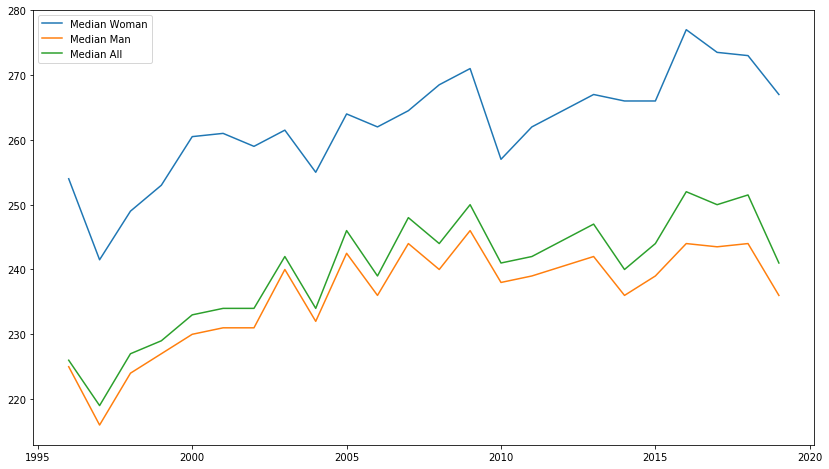

In [62]:
# Average times evolution

plt.plot(years, median_w)
plt.plot(years, median_m)
plt.plot(years, median_all)

plt.legend(['Median Woman','Median Man', "Median All"], loc='upper left')
plt.show()



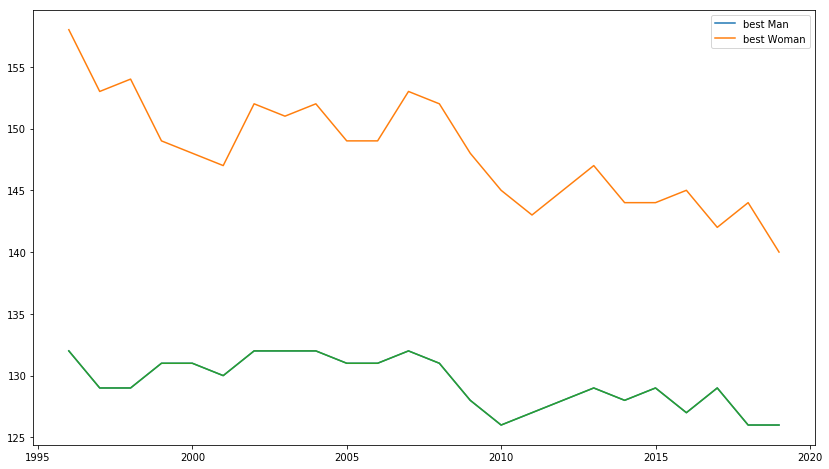

In [37]:
# Top times evolution

plt.plot(years, best_m)
plt.plot(years, best_w)

plt.legend(['best Man','best Woman'], loc='upper right')
plt.show()

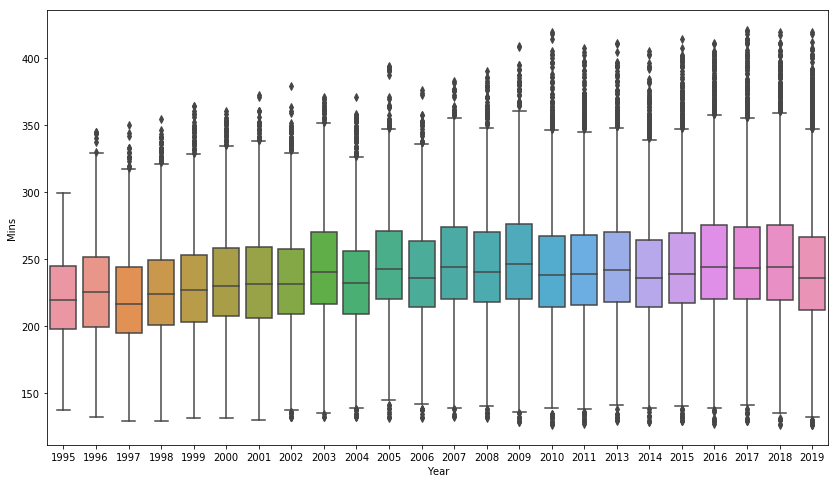

In [68]:
sns.boxplot(x='Year', y='Mins', data=df_man)


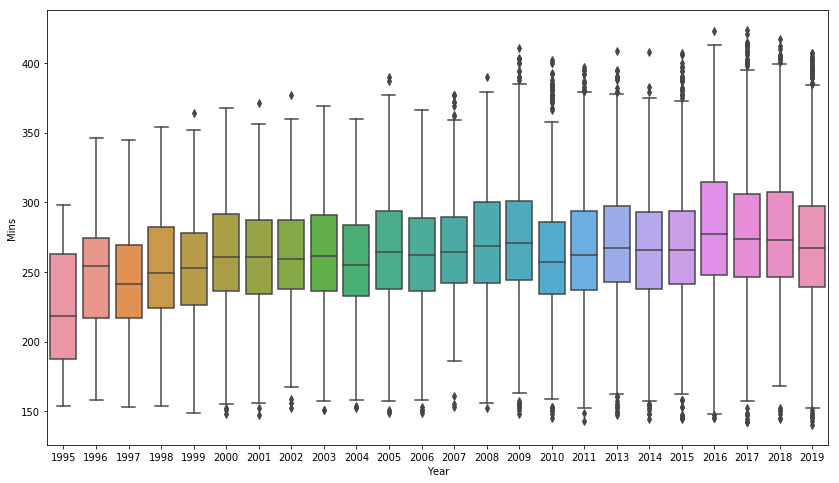

In [69]:
sns.boxplot(x='Year', y='Mins', data=df_woman)

{'whiskers': [<matplotlib.lines.Line2D at 0x218e04c7da0>,
 'caps': [<matplotlib.lines.Line2D at 0x218e04b46a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x218e04c7c50>,
 'medians': [<matplotlib.lines.Line2D at 0x218e04b4ef0>,
 'fliers': [<matplotlib.lines.Line2D at 0x218e04ab358>,
 'means': []}

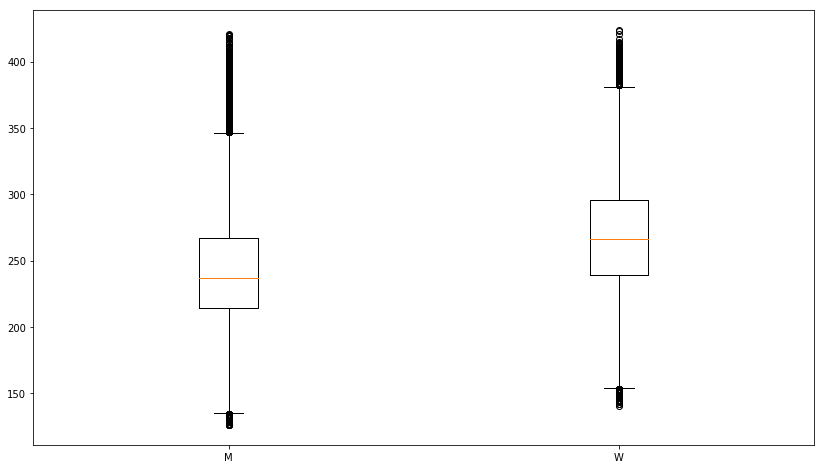

In [70]:
box_man = df_man['Mins']
box_woman = df_woman['Mins']
fig = plt.figure()
ax = fig.add_subplot(111)
ax.boxplot([box_man,box_woman], labels=['M', 'W'])

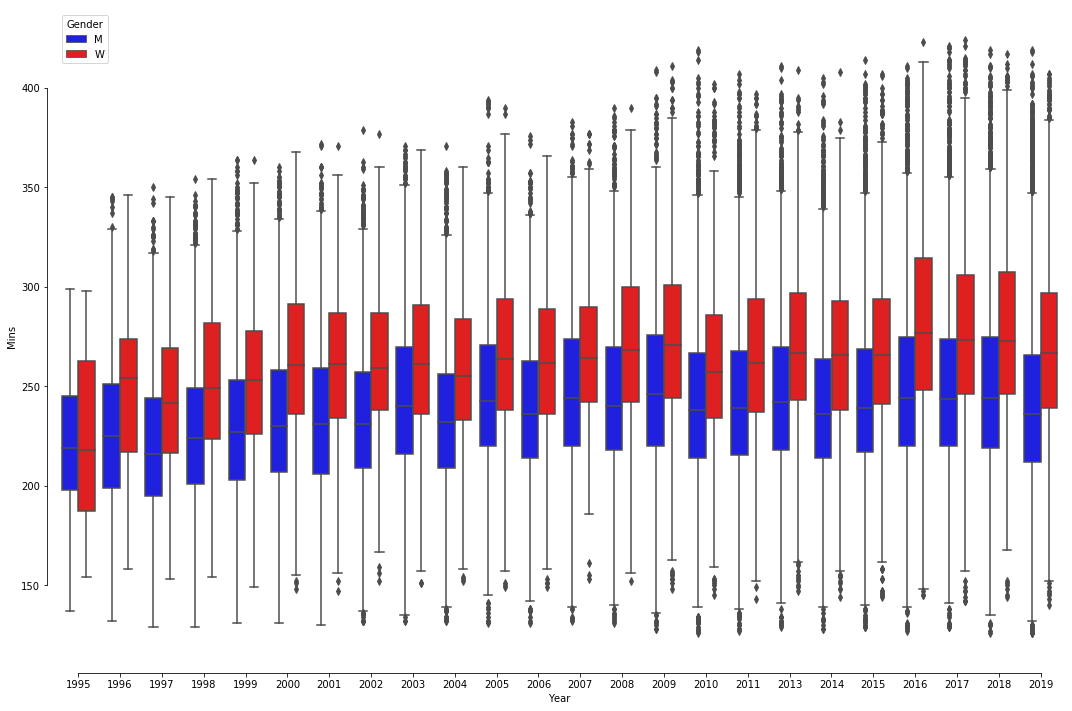

In [75]:
plt.rcParams["figure.figsize"]=(18,12)

sns.boxplot(x="Year", y="Mins",
            hue="Gender", palette=["b", "r"],
            data=df_genders)
sns.despine(offset=10, trim=True)

### Pivot tables 2/3

##### Nationality

##### -> Min + Mean rank
##### -> Min + Mean time


In [76]:
df_nations = df_final[df_final["Nationality"] != "-"]
pd.pivot_table(df_nations,index=["Nationality"],columns = ["Year"], values="Rank",aggfunc=np.min)

Year,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,...,2009,2010,2011,2013,2014,2015,2016,2017,2018,2019
Nationality,,,,,,,,,,,,,,,,,,,,,
ABW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4778.0,NaN,NaN,NaN
AFG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,683.0,5077.0,283.0,NaN,NaN,1689.0,1824.0
ALA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,5054.0,NaN,NaN,NaN,NaN,NaN
ALB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4824.0,4463.0,NaN,2281.0,2783.0,2740.0,3119.0,1958.0
ALG,NaN,7.0,26.0,NaN,NaN,NaN,NaN,NaN,12.0,NaN,...,1336.0,135.0,147.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AND,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2677.0,NaN,423.0,NaN,NaN,NaN,NaN,NaN,NaN
ARE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2904.0,NaN,NaN
ARG,NaN,NaN,1175.0,NaN,519.0,426.0,1762.0,247.0,619.0,NaN,...,1405.0,887.0,1030.0,2259.0,1690.0,2695.0,948.0,884.0,164.0,90.0
ARM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3008.0,NaN,3186.0


In [77]:

pd.pivot_table(df_nations,index=["Nationality"],columns = ["Year"], values="Mins",aggfunc=np.mean)


Year,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,...,2009,2010,2011,2013,2014,2015,2016,2017,2018,2019
Nationality,,,,,,,,,,,,,,,,,,,,,
ABW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,298.000000,NaN,NaN,NaN
AFG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,244.500000,290.000000,187.000000,NaN,NaN,229.500000,219.000000
ALA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,289.000000,NaN,NaN,NaN,NaN,NaN
ALB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,307.000000,278.000000,NaN,280.000000,252.000000,240.000000,251.000000,241.000000
ALG,NaN,132.000000,148.000000,NaN,NaN,NaN,NaN,NaN,148.000000,NaN,...,268.600000,224.500000,176.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AND,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,250.000000,NaN,197.000000,NaN,NaN,NaN,NaN,NaN,NaN
ARE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,242.000000,NaN,NaN
ARG,NaN,NaN,238.000000,NaN,201.000000,239.800000,262.750000,195.000000,258.125000,NaN,...,244.500000,209.000000,227.250000,273.571429,250.500000,254.000000,260.571429,261.375000,260.666667,231.750000
ARM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,246.000000,NaN,233.000000


In [78]:
pd.pivot_table(df_nations,index=["Nationality"],columns = ["Year"], values="Mins",aggfunc=np.min)


Year,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,...,2009,2010,2011,2013,2014,2015,2016,2017,2018,2019
Nationality,,,,,,,,,,,,,,,,,,,,,
ABW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,298.0,NaN,NaN,NaN
AFG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,206.0,290.0,187.0,NaN,NaN,223.0,219.0
ALA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,289.0,NaN,NaN,NaN,NaN,NaN
ALB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,307.0,278.0,NaN,236.0,252.0,240.0,249.0,214.0
ALG,NaN,132.0,148.0,NaN,NaN,NaN,NaN,NaN,137.0,NaN,...,231.0,171.0,176.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AND,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,250.0,NaN,197.0,NaN,NaN,NaN,NaN,NaN,NaN
ARE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,242.0,NaN,NaN
ARG,NaN,NaN,229.0,NaN,201.0,198.0,246.0,195.0,203.0,NaN,...,231.0,209.0,213.0,237.0,221.0,239.0,212.0,207.0,178.0,166.0
ARM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,246.0,NaN,233.0


In [ ]:


########################################################################xx
uq_countries = uq_countries[uq_countries != "-"]
# uq_countries

national_means = []

for i in uq_countries:
        country = df_nations[df_nations["Nationality"]== i]
        country_mean = country.Mins.mean()
        national_means.append(country_mean)

print(national_means)

In [ ]:
plt.plot(national_means)
plt.show()

### Pivot tables 3/3

##### Age and Years

##### -> Min + Mean rank
##### -> Min + Mean time


In [ ]:
uq_countries

### Medals

In [ ]:
# Here we count number of Gold/Silver/Bronze Medals for each country, W/M

medals = uq_countries

counter_g = 0
counter_s = 0
coutner_b = 0

for abc in uq_countries:
    if [(df_nations["Rank"]==1) & (df_nations["Nationality"]== abc)]:
        counter_g = counter_g+1
    elif [(df_nations["Rank"]==2) & (df_nations["Nationality"]== abc)]:
        counter_s = counter_s+1
    elif [(df_nations["Rank"]==3) & (df_nations["Nationality"]== abc)]:
        counter_b = counter_b+1
    else:
    medals.append(counter_g, counter_s, counter_b)
    
    ########################################################################
    ##Nedaří se mi uložit medaile....